## Deep Learning - Lab 06

* Full name: Đinh Anh Huy
* Student ID: 18110103

#### Bài tập 1.
**Hãy dùng bộ FastText 300d để làm embedding cho model.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import io
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.models import Model

import random
random.seed(1)

In [2]:
def plot_history(model_history, marker=None, figsize=(15,8)):
  plt.style.use("ggplot")
  fig, ax = plt.subplots(1, 2, figsize=figsize) 

  ax[0].plot(model_history.history['loss'], color='b', marker=marker, label='Training Loss')
  ax[0].plot(model_history.history['val_loss'], color='r', marker=marker, label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  ax[1].plot(model_history.history['accuracy'], color='b', marker=marker, label='Training  Accuracy')
  ax[1].plot(model_history.history['val_accuracy'], color='r', marker=marker, label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

In [3]:
# Download Punkt Tokenizer Models
nltk.download('punkt')

# Download and unzip Glove weigths
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
--2021-11-18 09:13:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-18 09:13:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-18 09:13:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request 

In [4]:
def tokenize(data):
  texts = data.to_list()
  texts = [txt.lower() for txt in texts]
  return [nltk.tokenize.word_tokenize(txt) for txt in texts]

def load_word_embeddings(fname):
  fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
  vocab, matrix = [], []
  i = 0
  for line in fin:
    tokens = line.rstrip().split(' ')
    vocab.append(tokens[0])
    matrix.append(list(map(float, tokens[1:])))
  return vocab, np.asarray(matrix)

def preprocessing_data(data, glove_fname=None):
  __PADDED_INDEX__ = 0
  __UNKNOWN_WORD__ = 1

  tokenized_texts = tokenize(data)

  if glove_fname is None:
    vocab, matrix = load_word_embeddings("glove.6B.100d.txt")
  else:
    vocab, matrix = load_word_embeddings(glove_fname)

  word_to_index = {word: index+2 for index, word in enumerate(vocab)}
  embedding_matrix = np.pad(matrix, pad_width=((2,0),(0,0)), mode='constant', constant_values=0.0)

  X = []
  for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
      if word in word_to_index:
        cur_text_indices.append(word_to_index[word])
      else:
        cur_text_indices.append(__UNKNOWN_WORD__)
    X.append(cur_text_indices)

  return tf.keras.preprocessing.sequence.pad_sequences(sequences=X, padding='post'), embedding_matrix

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [6]:
X, embedding_matrix = preprocessing_data(df['Text'], glove_fname='glove.6B.300d.txt')
y = df['y'].values

# Split data to training, validation and testing set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=43)

print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_valid.shape)

Shape of training set:  (4459, 215)
Shape of validation set:  (1115, 215)


#### Bài tập 2.
**Hãy tìm hiểu cách dùng của convolution 1D trong keras để train mô hình dưới đây**

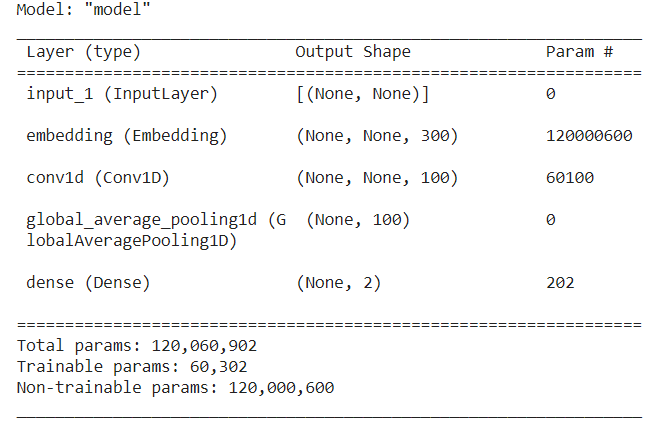

In [7]:
inputs = Input(shape=(None,))

embed = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  embeddings_initializer=tf.keras.initializers.Constant(value=embedding_matrix),
                  trainable=False,
                  mask_zero=True)(inputs)

conv1d = Conv1D(filters=100, 
                kernel_size=2,
                activation='relu',
                padding='same')(embed)

global_avg_pooling = GlobalAveragePooling1D()(conv1d)

dense = Dense(units=2, activation='softmax')(global_avg_pooling)

model = Model(inputs=inputs, outputs=dense)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         120000600 
                                                                 
 conv1d (Conv1D)             (None, None, 100)         60100     
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 60,302
Non-trainable params: 120,000,600
__________________________________________

In [8]:
BATCH_SIZE = 512
EPOCHS = 30
lr = 3e-3
decay = 1e-5

In [9]:
# init Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)

time_start = time.time()

# compile model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# fine-tune the model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid))

false_time = time.time() - time_start

Epoch 1/30
9/9 [==============================] - 16s 48ms/step - loss: 0.5616 - accuracy: 0.8643 - val_loss: 0.4667 - val_accuracy: 0.8610
Epoch 2/30
9/9 [==============================] - 0s 21ms/step - loss: 0.4345 - accuracy: 0.8672 - val_loss: 0.4275 - val_accuracy: 0.8610
Epoch 3/30
9/9 [==============================] - 0s 25ms/step - loss: 0.3866 - accuracy: 0.8672 - val_loss: 0.3621 - val_accuracy: 0.8610
Epoch 4/30
9/9 [==============================] - 0s 24ms/step - loss: 0.3245 - accuracy: 0.8713 - val_loss: 0.2946 - val_accuracy: 0.8942
Epoch 5/30
9/9 [==============================] - 0s 23ms/step - loss: 0.2525 - accuracy: 0.9161 - val_loss: 0.2221 - val_accuracy: 0.9363
Epoch 6/30
9/9 [==============================] - 0s 24ms/step - loss: 0.1860 - accuracy: 0.9446 - val_loss: 0.1735 - val_accuracy: 0.9444
Epoch 7/30
9/9 [==============================] - 0s 23ms/step - loss: 0.1431 - accuracy: 0.9567 - val_loss: 0.1475 - val_accuracy: 0.9534
Epoch 8/30
9/9 [==========

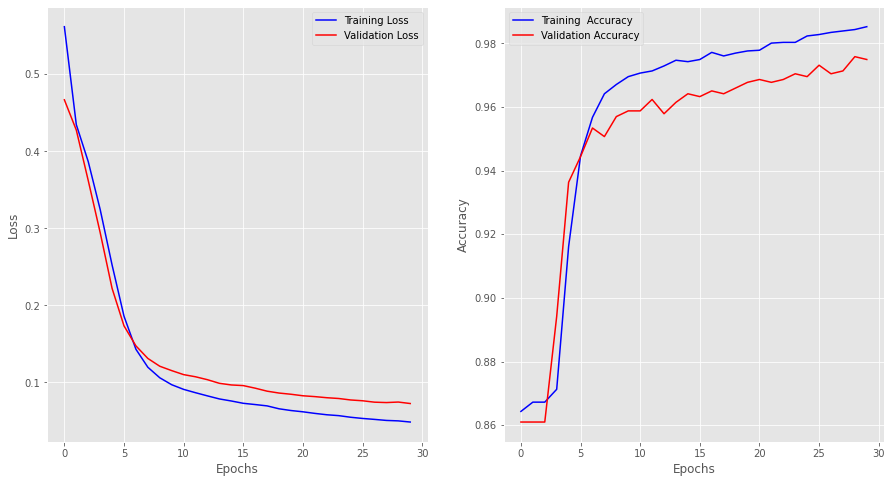

In [10]:
plot_history(history, figsize=(15,8))

#### Bài tập 3.
**Xét 2 trường hợp `trainable` là `True` và `False` trong lớp embedding và đưa ra so sánh.**

In [11]:
inputs_2 = Input(shape=(None,))

embed_2 = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  embeddings_initializer=tf.keras.initializers.Constant(value=embedding_matrix),
                  trainable=True,
                  mask_zero=True)(inputs_2)

conv1d_2 = Conv1D(filters=100, 
                kernel_size=2,
                activation='relu',
                padding='same')(embed_2)

global_avg_pooling_2 = GlobalAveragePooling1D()(conv1d_2)

dense_2 = Dense(units=2, activation='softmax')(global_avg_pooling_2)

model_2 = Model(inputs=inputs_2, outputs=dense_2)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         120000600 
                                                                 
 conv1d_1 (Conv1D)           (None, None, 100)         60100     
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 120,060,902
Non-trainable params: 0
_____________________________________________

In [12]:
time_start = time.time()

# compile model
model_2.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# fine-tune the model
history_2 = model_2.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid))

truth_time = time.time() - time_start

Epoch 1/30
9/9 [==============================] - 1s 84ms/step - loss: 0.4854 - accuracy: 0.7899 - val_loss: 0.3997 - val_accuracy: 0.8610
Epoch 2/30
9/9 [==============================] - 1s 65ms/step - loss: 0.2822 - accuracy: 0.8850 - val_loss: 0.1497 - val_accuracy: 0.9632
Epoch 3/30
9/9 [==============================] - 1s 70ms/step - loss: 0.0885 - accuracy: 0.9733 - val_loss: 0.0848 - val_accuracy: 0.9722
Epoch 4/30
9/9 [==============================] - 1s 68ms/step - loss: 0.0436 - accuracy: 0.9843 - val_loss: 0.0605 - val_accuracy: 0.9785
Epoch 5/30
9/9 [==============================] - 1s 66ms/step - loss: 0.0251 - accuracy: 0.9926 - val_loss: 0.0490 - val_accuracy: 0.9883
Epoch 6/30
9/9 [==============================] - 1s 67ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0465 - val_accuracy: 0.9883
Epoch 7/30
9/9 [==============================] - 1s 66ms/step - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0445 - val_accuracy: 0.9892
Epoch 8/30
9/9 [===========

Trainable parameter is True


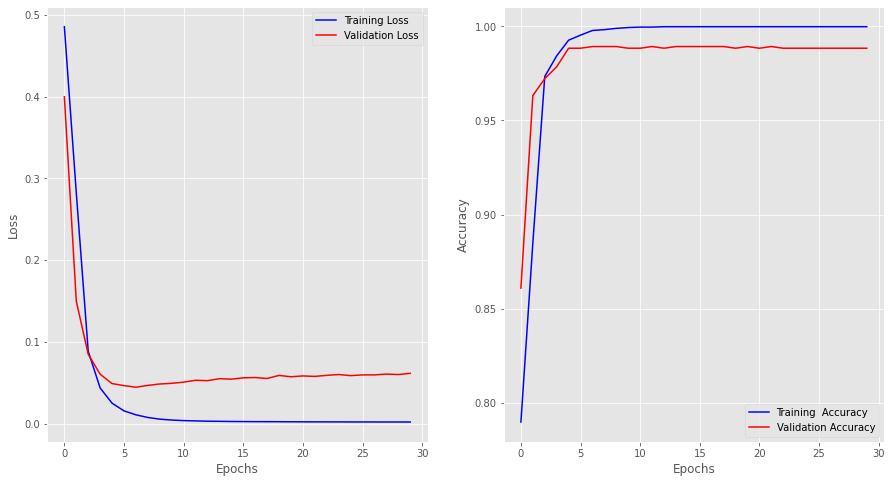

In [13]:
print("Trainable parameter is True");
plot_history(history_2, figsize=(15,8))

Trainable parameter is False


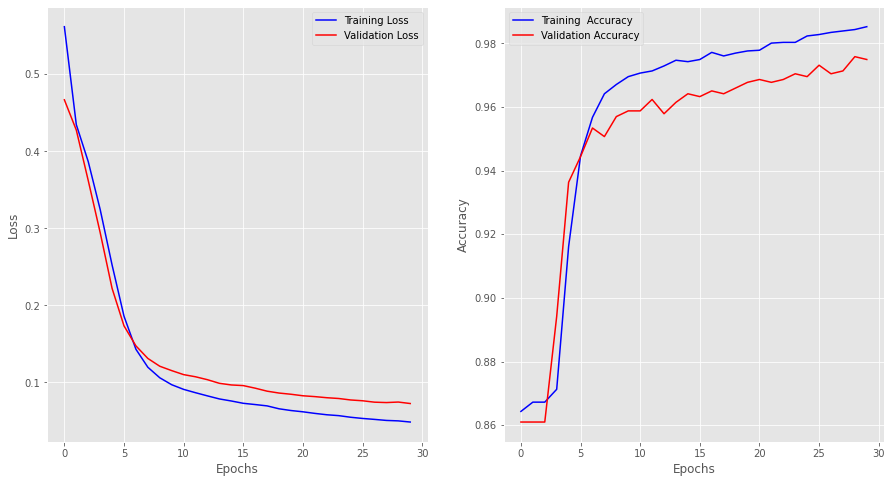

In [14]:
print("Trainable parameter is False");
plot_history(history, figsize=(15,8))

In [15]:
print(">> Total time in trainable parameter of ebedding layer is False: ", false_time)
print(">> Total time in trainable parameter of ebedding layer is True: ", truth_time)

>> Total time in trainable parameter of ebedding layer is False:  22.592647314071655
>> Total time in trainable parameter of ebedding layer is True:  18.59912085533142


**Nhận xét:**
* Tham số `trainable` trong embedding layer có chức năng thông báo cho mô hình có cập nhật lại bộ word weights ở mỗi lần embedding với tập dữ liệu đang sử dụng hay không (tương ứng True là cập nhật và False là giữ nguyên).

* Từ 2 đồ thị biểu diễn training và validation loss và accuracy trong 2 trường hợp giá trị của `trainable` parameter, ta thấy rằng:
  * Trong trường hợp `trainbale = True`, training accuracy $\approx 0.9998$ và validation accuracy $\approx 0.9883$.
  * Trong trường hợp `trainalbe = False`, training accuracy $\approx 0.9852$ và validation accuracy $\approx 0.9750$.

  Ta có thể trường hợp `trainable = True` cho ra kết quả tốt hơn (một chút).

* Thời gian train của trường hợp  `trainable = True` cũng ngắn hơn (khoảng 4 giây) so với trường hợp còn lại.